## Create Grid data forARMOR

We define a grids which covers a smaller domain typically 80 km x 80 km x 15 km in (x, y, z) with higher resolution of 250 m in all dimensions. In this notebook the radar data used are from ARMOR. This notebook includes processes for  1) noise masking, 2) velocity unfolding using PyART, 3) gridding using Berns metiond (North et al. 2017)

### Import important functions

In [1]:
%matplotlib inline
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import BoundaryNorm
# PyART functions
from pyart.graph import cm
from pyart.io import read
from pyart.io import write_grid
from pyart.filters import GateFilter
from pyart.correct.region_dealias import dealias_region_based
from pyart.correct.unwrap import dealias_unwrap_phase
from pyart.correct import calculate_attenuation
# North et al. (2017) gridding code
from grid.core import Weight, Domain
from grid.interp import mapper

### Helper functions

In [2]:
def _plot_ppi(radar, field, sweep=0, max_range=40.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse radar sweep coordinates
    _range = radar.range['data'] / 1000.0
    azimuth = np.radians(radar.get_azimuth(sweep))
    idx = np.abs(_range - max_range).argmin()
    
    # Compute (x, y) coordinates
    AZI, RNG = np.meshgrid(azimuth, _range[:idx+1], indexing='ij')
    X = RNG * np.sin(AZI)
    Y = RNG * np.cos(AZI)
    
    # Parse radar field data
    data = radar.get_field(sweep, field)[:,:idx+1]
    
    # Create quadmesh
    qm = ax.pcolormesh(
        X, Y, data, cmap=cmap, norm=norm, alpha=None, shading='flat', rasterized=True)
    
    # Create colour bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    title = '{} {:.1f} deg\n{}'.format(
        radar.metadata['instrument_name'], radar.fixed_angle['data'][sweep], field)
    ax.set_title(title)
    
    return


def _plot_cappi(grid, field, height=0, scale=1.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse grid coordinates
    x_disp = grid.axes['x_disp']['data'] / 1000.0
    y_disp = grid.axes['y_disp']['data'] / 1000.0
    z_disp = grid.axes['z_disp']['data'] / 1000.0
    
    # Create quadmesh
    qm = ax.pcolormesh(
        x_disp, y_disp, scale * grid.fields[field]['data'][height], cmap=cmap, 
        norm=norm, alpha=None, shading='flat', rasterized=True)
    
    # Create colour bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    title = '{:.1f} km\n{}'.format(z_disp[height], field)
    ax.set_title(title)
    
    return

In [3]:
# Define colour maps
cmap_refl = cm.NWSRef
cmap_vdop = cm.NWSVel
cmap_spw = cm.NWS_SPW
cmap_rhohv = cm.Carbone17
cmap_zdr = cm.RefDiff
cmap_phidp = cm.Wild25
cmap_kdp = cm.Theodore16
cmap_ncp = cm.Carbone17
cmap_class = cm.Carbone11
cmap_dist = cm.BlueBrown10
cmap_weight = cm.Carbone17
cmap_time = cm.BlueBrown10

# Normalize colour maps
norm_refl = BoundaryNorm(np.arange(-20, 61, 1), cmap_refl.N)
norm_vdop = BoundaryNorm(np.arange(-32, 36, 4), cmap_vdop.N)
norm_spw = BoundaryNorm(np.arange(0, 10.1, 0.1), cmap_spw.N)
norm_rhohv = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_rhohv.N)
norm_zdr = BoundaryNorm(np.arange(-6.0, 6.5, 0.5), cmap_zdr.N)
norm_phidp = BoundaryNorm(np.arange(-180, 95, 5), cmap_phidp.N)
norm_kdp = BoundaryNorm(np.arange(-2, 8.2, 0.2), cmap_kdp.N)
norm_ncp = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_ncp.N)
norm_class = BoundaryNorm(np.arange(0, 7, 1), cmap_class.N)
norm_dist = BoundaryNorm(np.arange(0, 2.1, 0.1), cmap_dist.N)
norm_weight = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_weight.N)
norm_time = BoundaryNorm(np.arange(0, 250, 10), cmap_time.N)

# Define colour bar ticks
ticks_refl = np.arange(-20, 65, 5)
ticks_vdop = np.arange(-32, 40, 8)
ticks_spw = np.arange(0, 10, 2)
ticks_rhohv = np.arange(0, 1.2, 0.2)
ticks_zdr = np.arange(-6, 8, 2)
ticks_phidp = np.arange(-180, 120, 30)
ticks_kdp = np.arange(-2, 10, 2)
ticks_ncp = np.arange(0, 1.2, 0.2)
ticks_class = np.arange(0, 7, 1)
ticks_dist = np.arange(0, 2.4, 0.4)
ticks_weight = np.arange(0, 1.2, 0.2)
ticks_time = np.arange(0, 280, 40)

#### Grid setting

In [4]:
# set a common grid
coords = [
    np.arange(0.0, 15250.0, 250.0),
    np.arange(-40000, 40250, 250),
    np.arange(-40000, 40250, 250)
    ]

lat_origin=35.356
lon_origin=-86.845

# Define grid origin                                                                                                                                                                               
origin = (lat_origin, lon_origin, 0)


#### Read ARMOR radar data

In [38]:
filename = '/data1/moue/ARMOR/20230401/ARMR20230401071733.nc'
#filename = '/data1/moue/ARMOR/20080411/RAW_NA_000_125_20080411182229.gz'
outfilename='/data1/moue/ARMOR/grid/'+filename[-17:-9]+'/grid_'+ filename[-21:-3]+'.nc'
print outfilename
radar = read(filename, exclude_fields=None)
# List available fields                                                                                                                                                                            
for field in radar.fields.keys():
    print field
    
# for CFRadial data
ref_field='CFREF'
vel_field='VEL'
rhv_field='RHO'
spw_field='SW'
zdr_field='ZDR'
php_field='PHI'
#FOR RAW data
#ref_field='reflectivity'
#vel_field='velocity'
#rhv_field='cross_correlation_ratio'
#spw_field='spectrum_width'
#zdr_field='differential_reflectivity'
#php_field='differential_phase'

az_offset = 3;
radar.azimuth['data']=radar.azimuth['data'][:]-az_offset

 #15.98933
nyquist_vel = [radar.get_nyquist_vel(i, None) for i in
                       range(radar.nsweeps)]
print nyquist_vel


/data1/moue/ARMOR/grid/20230401/grid_ARMR20230401071733.nc
PHI
CFREF
SW
HPower
ZDR
SNR
RHO
VEL
REF
[15.989333152770996, 15.989333152770996, 15.989333152770996, 15.989333152770996, 15.989333152770996, 15.989333152770996, 15.989333152770996, 15.989333152770996, 15.989333152770996]


#### ARMOR velocity data dealiasing

In [39]:

ref = radar.fields[ref_field]['data']
vel = radar.fields[vel_field]['data']
rhv = radar.fields[rhv_field]['data']
spw = radar.fields[spw_field]['data']

# mask noise in velocity
is_messy = ref < -30.0
vel = np.ma.masked_where(is_messy, vel)
is_messy = ref > 100.0
vel = np.ma.masked_where(is_messy, vel)
is_messy = rhv < 0.8
vel = np.ma.masked_where(is_messy, vel)
is_messy = spw > 7
vel = np.ma.masked_where(is_messy, vel)
field_dict = {'data' : vel}
for key in ['long_name', 'units', #'valid_min', 'valid_max',                                                                                                                         
            'standard_name', 'coordinates']:
    field_dict.update({key : radar.fields[vel_field][key]})
radar.add_field('masked_velocity', field_dict)
    
# mask noise in reflectivity
is_messy = ref > 100.0
ref = np.ma.masked_where(is_messy, ref)
is_messy = ref < -30.0
ref = np.ma.masked_where(is_messy, ref)
is_messy = rhv < 0.8
ref = np.ma.masked_where(is_messy, ref)
is_messy = spw > 7
ref = np.ma.masked_where(is_messy, ref)
field_dict = {'data' : ref}
for key in ['long_name', 'units', #'valid_min', 'valid_max',                                                                                                                         
            'standard_name', 'coordinates']:
    field_dict.update({key : radar.fields[ref_field][key]})
radar.add_field('masked_reflectivity', field_dict)
#Filtering                                                                                                                                                                                         
gf = GateFilter(radar)
gf.exclude_masked('masked_velocity')
#Dealias  
dealias_vel = dealias_region_based(
    radar,nyquist_vel=15.9897, vel_field='masked_velocity',interval_splits=3,check_nyquist_uniform=None,gatefilter=gf)
    
#dealias_vel = dealias_region_based(
#        radar, interval_splits=4, interval_limits=None, vel_field='masked_velocity',
#        keep_original=False, nyquist_vel=None, check_nyquist_uniform=True,
#        rays_wrap_around=True, set_limits=False)
radar.add_field('corrected_velocity', dealias_vel)
#

(400, 800)
(401, 800)
(401, 800)
(401, 800)
(400, 800)
(401, 800)
(401, 800)
(401, 800)
(401, 800)


#### Plot PPI to check dealiasing velocity

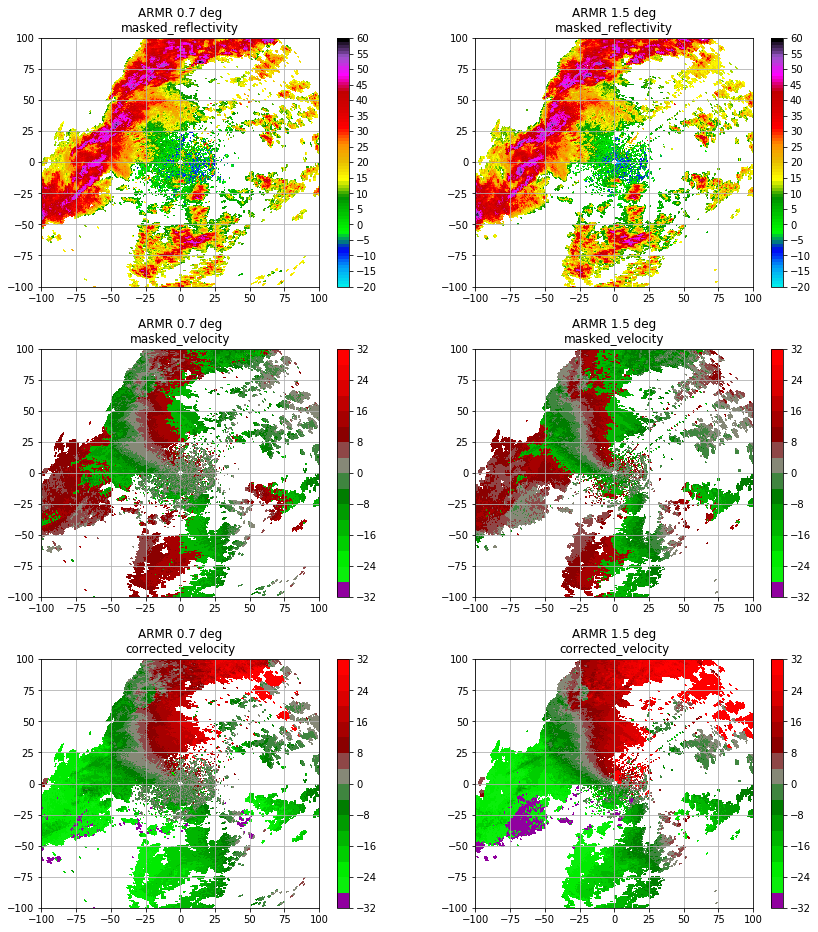

In [40]:
figs = {'figsize': (14, 16)}
subs = {'xlim': (-100, 100), 'ylim': (-100, 100)}
fig, axes = plt.subplots(nrows=3, ncols=2, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.25, hspace=0.25)

max_range = 500.0
sweeps = [0, 1]
#sweeps = [ 8, 9]

for i, sweep in enumerate(sweeps):
    
    # (a) Reflectivity
    _plot_ppi(radar, 'masked_reflectivity', sweep=sweep, max_range=max_range, cmap=cmap_refl, 
          norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Doppler velocity
    _plot_ppi(radar, 'masked_velocity', sweep=sweep, max_range=max_range, cmap=cmap_vdop, 
              norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    # (c) Spectrum width
    _plot_ppi(radar, 'corrected_velocity', sweep=sweep, max_range=max_range, cmap=cmap_vdop, 
              norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[2,i])
         
for ax in axes.flat:
    ax.grid(which='major')

In [41]:
# Define fields to grid                                                                                                                                                                            
fields = [
        'masked_reflectivity',
        'corrected_velocity',
        'masked_velocity',
        spw_field,
        rhv_field,
        zdr_field,
        php_field,
        ]

# Create grid domain                                                                                                                                                                               
domain = Domain(coords, origin, proj='lcca', ellps='WGS84', datum='WGS84', dem=None)


In [42]:
print radar.fixed_angle['data']

[ 0.7        1.5        2.5        3.6        4.7999997  6.
  7.5        9.        11.       ]


In [43]:
#== Gridding using Isotropic Barnes                                                                                                                                                                               
#number of data points and data_spaciing
nk = 100; wspacing = 500.0;   
#- Define analysis weight                                                                                                                                                                          
weight = Weight(
    func=None, cutoff_radius=np.inf, k=nk, kappa_star=0.5, data_spacing=wspacing)
weight.compute_distance_weight_vanishes(atol=0.001, verbose=True)

#- Gridding
grid = mapper.grid_radar(
    radar, domain, weight=weight, fields=fields, toa=17000.0, gatefilter=gf,
    max_range=None, legacy=True, debug=True, verbose=True)

#- Add metadata
#radarname= 'wsr88d-'+  filename[-23:-19]
#grid.metadata['radar_0_instrument_name'] = radarname
grid.metadata['site_id'] = 'seus'
grid.metadata['references']='North et al. (2017)'
grid.metadata['refered_file']=filename[-21:]


Distance weight vanishes: 1900.00 m
Radar x in grid: 6.74 km
Radar y in grid: -78.75 km
Radar z in grid: 0.22 km
Number of radar gates before pruning: 2885600
Number of radar gates below TOA: 2740394
Number of x grid points: 321
Number of y grid points: 321
Number of z grid points: 61
Grid 1-D array shape: (6285501,)
No radar kd-tree exists
Creating k-d tree instance for radar gate locations
tree.m = 3
tree.n = 2740394
Querying k-d tree for the k-nearest analysis grid points
Elapsed time for query: 116.59 sec
Distance array shape: (6285501, 100)
Minimum gate-grid distance: 1.08 m
Maximum gate-grid distance: 8197.98 m
Index array shape: (6285501, 100)
Minimum index: 80390
Maximum index: 2740393
Computing distance-dependent weights
Number of invalid indices: 0
Number of analysis points too far from radar: 59299
Mapping radar field: masked_reflectivity
Mapping radar field: corrected_velocity
Mapping radar field: masked_velocity
Mapping radar field: SW
Mapping radar field: RHO
Mapping rada

/home/moue/projects/pyart/pyart/core/grid.py:182: DeprecationWarning: from_legacy_parameters is deprecated and will be removed in a future version of Py-ART
  "future version of Py-ART", DeprecationWarning)


#### Plot CAPPI

ARMR20230401071733


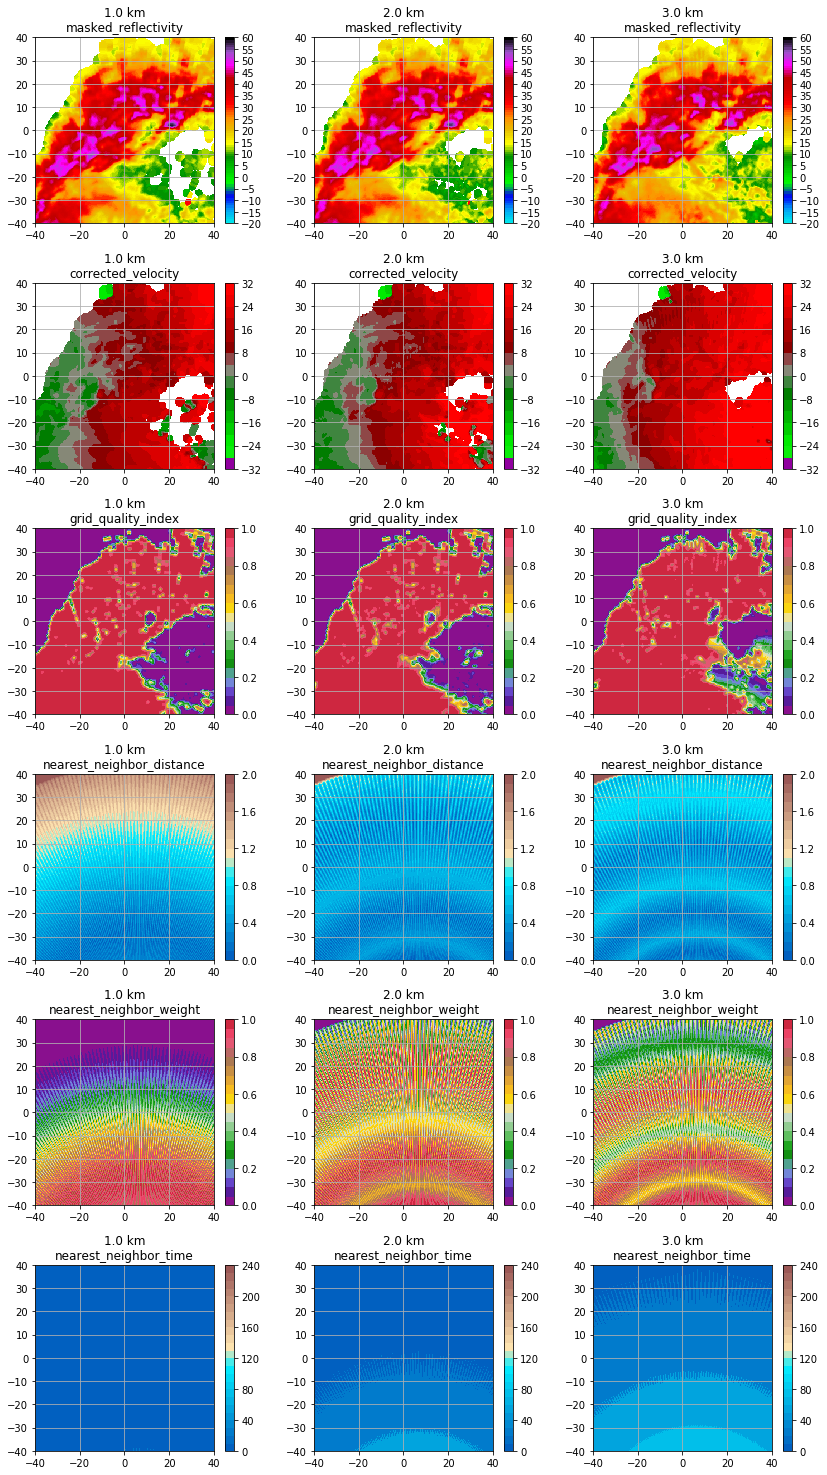

In [46]:
figs = {'figsize': (14, 26)}
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
fig, axes = plt.subplots(nrows=6, ncols=3, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.25, hspace=0.32)

heights = [4,8,12]
print filename[-21:-3]
for i, height in enumerate(heights):
    
    # Reflectivity
    _plot_cappi(grid, 'masked_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # Doppler velocity
    _plot_cappi(grid, 'corrected_velocity', height=height, cmap=cmap_vdop, 
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    #  Grid quality index
    _plot_cappi(grid, 'grid_quality_index', height=height, cmap=cmap_ncp,
                norm=norm_ncp, ticks=ticks_ncp, fig=fig, ax=axes[2,i])
        
    #  Nearest neighbour distance
    _plot_cappi(grid, 'nearest_neighbor_distance', height=height, scale=1.0e-3, 
                cmap=cmap_dist, norm=norm_dist, ticks=ticks_dist, fig=fig, 
                ax=axes[3,i])
    
    # Nearest neighbour weight
    _plot_cappi(grid, 'nearest_neighbor_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[4,i])
    
    # Nearest neighbour time
    _plot_cappi(grid, 'nearest_neighbor_time', height=height, cmap=cmap_time, 
                norm=norm_time, ticks=ticks_time, fig=fig, ax=axes[5,i])

# Format axes
for ax in axes.flat:
    ax.grid(which='major')

#### Write to output file

In [45]:
print outfilename
write_grid(outfilename, grid)

/data1/moue/ARMOR/grid/20230401/grid_ARMR20230401071733.nc
